# Load Libraries

In [1]:
import os
import warnings
import logging
import sys
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import dotenv
import pyet

# Load environment variables from .env file
dotenv.load_dotenv()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Load Data

In [2]:
# Load Data From Pickle
with open('../../data/Data_Iran_1983_2022.pkl', 'rb') as f:
    data = pickle.load(f)
    logging.info("Data loaded from pickle file.")

INFO:root:Data loaded from pickle file.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260534 entries, 0 to 3260533
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   station_id         category      
 1   station_name       category      
 2   region_id          category      
 3   region_name        category      
 4   lat                float64       
 5   lon                float64       
 6   station_elevation  float64       
 7   date               datetime64[ns]
 8   tmax               float64       
 9   tmin               float64       
 10  tm                 float64       
 11  umax               float64       
 12  umin               float64       
 13  um                 float64       
 14  ffm                float64       
 15  sshn               float64       
 16  rrr24              float64       
dtypes: category(4), datetime64[ns](1), float64(12)
memory usage: 342.1 MB


# Calculate ETo

#### Data Quality Control

In [4]:
def data_quality_control(
    df, 
    required_vars = ['tm']
):
    # Remove duplicates
    df = df[~df.duplicated(keep='first')]
    # Drop rows with missing essential variables
    df = df.dropna(subset=required_vars)
    # Clip or filter out physically impossible values (example thresholds, adjust as needed)
    if 'tm' in required_vars:
        df = df[(df['tm'] > -50) & (df['tm'] < 60)]
    if 'tmax' in required_vars:
        df = df[(df['tmax'] > -50) & (df['tmax'] < 70)]
    if 'tmin' in required_vars:
        df = df[(df['tmin'] > -60) & (df['tmin'] < 50)]
    if 'ffm' in required_vars:
        df = df[(df['ffm'] >= 0) & (df['ffm'] < 50)]
    if 'umin' in required_vars:
        df = df[(df['umin'] >= 0) & (df['umin'] <= 100)]
    if 'umax' in required_vars:
        df = df[(df['umax'] >= 0) & (df['umax'] <= 100)]
    if 'um' in required_vars:
        df = df[(df['um'] >= 0) & (df['um'] <= 100)]
    if 'sshn' in required_vars:
        df = df[(df['sshn'] >= 0) & (df['sshn'] <= 24)]
    return df

#### Calculate ETo

In [5]:

def calculate_eto(group):
    print(f"Calculating ETo for station {group.name}")
    group = data_quality_control(
        df=group, 
        required_vars=['tm', 'tmax', 'tmin', 'ffm', 'umin', 'umax', 'um', 'sshn', 'lat', 'station_elevation']
    )
    group = group.set_index('date').sort_index()

    # If group is empty after cleaning, return NaNs
    if group.empty:
        return pd.Series(np.nan, index=group.index)

    lat = pyet.utils.deg_to_rad(lat=group['lat'].iloc[0])
    elevation = group['station_elevation'].iloc[0]
    rs = pyet.calc_rad_sol_in(n=group['sshn'], lat=lat, as1=0.25, bs1=0.5, nn=None)    
    wind = group['ffm']
    tmean = group['tm']
    tmax = group["tmax"]
    tmin = group["tmin"]
    rh = group["um"]
    rhmax = group["umin"]
    rhmin = group["umax"]

    eto = pyet.calculate_all(
        tmean=tmean,
        wind=wind,
        rs=rs,
        elevation=elevation,
        lat=lat,
        tmax=tmax,
        tmin=tmin,
        rh=rh,
        rhmax=rhmax,
        rhmin=rhmin
    )
    return eto


eto_df = data.groupby(
    ['region_id', 'station_id'],
    group_keys=True
).apply(calculate_eto)

Calculating ETo for station ('ALKK', '40752')
Calculating ETo for station ('ALKK', '88125')
Calculating ETo for station ('ALKK', '90220')
Calculating ETo for station ('ALKK', '99321')
Calculating ETo for station ('ALKK', '99373')
Calculating ETo for station ('ALKK', '99396')
Calculating ETo for station ('MAAA', '40769')
Calculating ETo for station ('MAAA', '40891')
Calculating ETo for station ('MAAA', '99372')
Calculating ETo for station ('MAAA', '99398')
Calculating ETo for station ('MAAA', '99409')
Calculating ETo for station ('MAAA', '99410')
Calculating ETo for station ('MAAA', '99412')
Calculating ETo for station ('MAAA', '99424')
Calculating ETo for station ('MAAA', '99432')
Calculating ETo for station ('MAAA', '99439')
Calculating ETo for station ('MAAA', '99441')
Calculating ETo for station ('MAAA', '99443')
Calculating ETo for station ('MAAA', '99461')
Calculating ETo for station ('MASA', '40732')
Calculating ETo for station ('MASA', '40734')
Calculating ETo for station ('MASA

#### Join ETo with Original Data

In [6]:
if isinstance(eto_df.index, pd.MultiIndex):
    eto_df = eto_df.reset_index()
    data = pd.merge(data, eto_df, on=['region_id', 'station_id', 'date'], how='left')
else:
    data = data.join(eto_df)

data.head()

,station_id,station_name,region_id,region_name,lat,lon,station_elevation,date,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,Penman,FAO-56,Priestley-Taylor,Kimberly-Penman,Thom-Oliver,Blaney-Criddle,Hamon,Romanenko,Linacre,Haude,Turc,Jensen-Haise,Mcguinness-Bordne,Hargreaves,FAO-24,Abtew,Makkink,Oudin,0
0,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-01 12:00:00,8.40,-0.80,4.60,73.00,41.00,58.00,0.00,7.00,0.10,0.73,0.58,0.72,0.57,0.99,0.61,0.59,2.40,1.69,1.25,0.89,0.77,0.94,1.04,1.09,2.16,1.33,0.64,NaN
1,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-02 12:00:00,13.40,NaN,8.70,68.00,38.00,52.33,0.00,6.30,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-03 12:00:00,8.80,0.40,4.60,89.00,45.00,63.33,0.00,7.70,0.00,0.75,0.64,0.79,0.63,0.93,0.61,0.60,1.68,1.53,1.12,0.94,0.83,0.95,1.00,1.14,2.30,1.42,0.64,NaN
3,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-04 12:00:00,5.40,-1.00,1.70,67.00,51.00,60.00,0.00,8.20,0.00,0.69,0.55,0.67,0.54,0.94,0.33,0.50,2.01,1.08,0.97,0.42,0.53,0.66,0.76,1.09,2.39,1.34,0.45,NaN
4,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-05 12:00:00,4.80,-4.00,0.40,69.00,47.00,52.67,0.00,8.30,0.00,0.67,0.54,0.66,0.53,0.90,0.21,0.46,1.79,1.04,1.10,0.11,0.39,0.53,0.83,1.09,2.42,1.29,0.36,NaN


#### Fill Missing Dates

In [7]:
# Fill missing dates for each station with NaN
all_dates = pd.date_range(data['date'].min(), data['date'].max(), freq='D')

def reindex_station(station_df):
    return station_df.set_index('date').reindex(all_dates).assign(
        region_id=station_df['region_id'].iloc[0],
        region_name=station_df['region_name'].iloc[0],
        station_id=station_df['station_id'].iloc[0],
        station_name=station_df['station_name'].iloc[0],
        station_elevation=station_df['station_elevation'].iloc[0],
        lat=station_df['lat'].iloc[0],
        lon=station_df['lon'].iloc[0],
    ).reset_index().rename(columns={'index': 'date'})

result = (
    data.groupby(['region_id', 'region_name', 'station_id', 'station_name', 'station_elevation', 'lat', 'lon'], group_keys=False)
    .apply(reindex_station)
    .reset_index(drop=True)
)

result

,date,station_id,station_name,region_id,region_name,lat,lon,station_elevation,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,Penman,FAO-56,Priestley-Taylor,Kimberly-Penman,Thom-Oliver,Blaney-Criddle,Hamon,Romanenko,Linacre,Haude,Turc,Jensen-Haise,Mcguinness-Bordne,Hargreaves,FAO-24,Abtew,Makkink,Oudin,0
0,1983-01-01 12:00:00,40752,Karaj,ALKK,Alborz,35.81,50.95,1292.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1983-01-02 12:00:00,40752,Karaj,ALKK,Alborz,35.81,50.95,1292.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1983-01-03 12:00:00,40752,Karaj,ALKK,Alborz,35.81,50.95,1292.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1983-01-04 12:00:00,40752,Karaj,ALKK,Alborz,35.81,50.95,1292.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1983-01-05 12:00:00,40752,Karaj,ALKK,Alborz,35.81,50.95,1292.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6252647,2022-12-26 12:00:00,99440,Kahak,QOQM,Qom,34.40,50.87,1403.10,10.50,1.30,4.60,81.00,44.00,66.38,2.00,6.40,0.00,0.97,1.23,0.83,1.56,1.11,0.62,0.60,2.01,1.44,1.15,0.87,0.75,0.97,1.07,1.11,2.10,1.32,0.66,NaN
6252648,2022-12-27 12:00:00,99440,Kahak,QOQM,Qom,34.40,50.87,1403.10,7.40,-1.40,3.20,90.00,57.00,77.12,2.12,0.70,0.40,0.74,0.85,0.69,1.11,0.76,0.49,0.55,1.23,1.54,0.64,0.38,0.30,0.83,0.98,0.32,1.04,0.62,0.56,NaN
6252649,2022-12-28 12:00:00,99440,Kahak,QOQM,Qom,34.40,50.87,1403.10,6.60,1.90,2.60,92.00,55.00,73.25,2.50,2.80,0.01,0.81,0.98,0.72,1.37,0.83,0.43,0.53,1.29,1.09,0.70,0.41,0.38,0.77,0.70,0.57,1.43,0.84,0.52,NaN
6252650,2022-12-29 12:00:00,99440,Kahak,QOQM,Qom,34.40,50.87,1403.10,11.50,-3.20,3.10,64.00,37.00,51.38,2.75,9.00,0.00,1.14,1.67,0.80,2.41,1.32,0.48,0.55,2.45,1.35,1.78,0.76,0.75,0.82,1.27,1.55,2.60,1.55,0.56,NaN


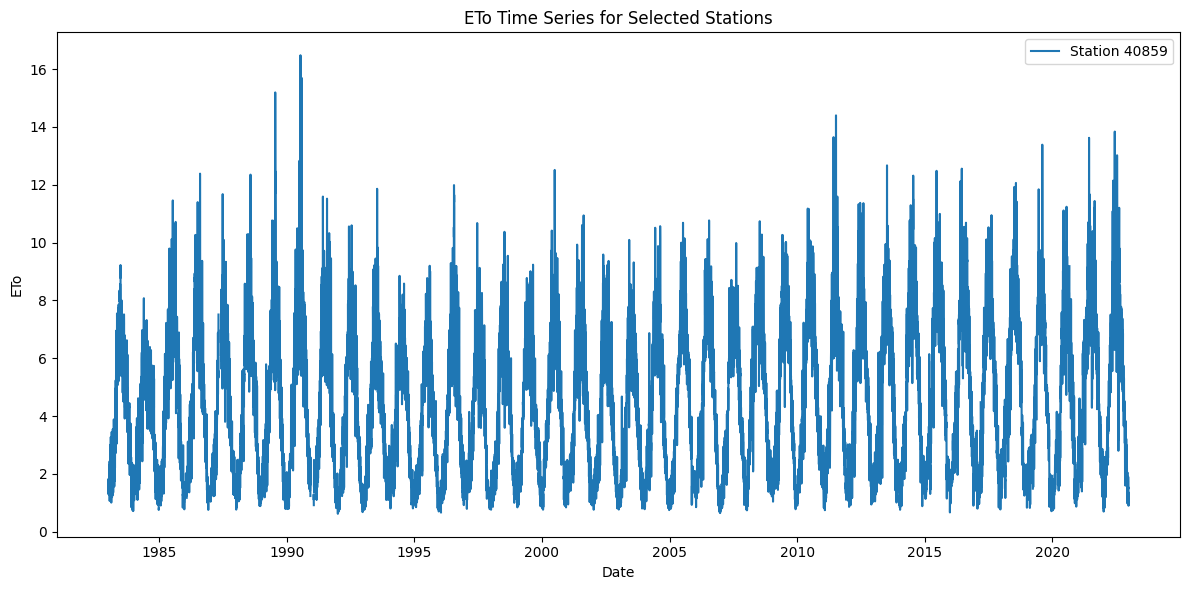

In [60]:
import matplotlib.pyplot as plt

# Select a few station_ids to plot (change as needed)
stations_to_plot = result['station_id'].drop_duplicates().sample(1)

plt.figure(figsize=(12, 6))
for sid in stations_to_plot:
    station_data = result[result['station_id'] == sid].sort_values('date')
    plt.plot(station_data['date'], station_data['FAO-56'], label=f'Station {sid}')

plt.xlabel('Date')
plt.ylabel('ETo')
plt.title('ETo Time Series for Selected Stations')
plt.legend()
plt.tight_layout()
plt.show()

# Export Data

In [62]:
# To pickle in data folder
with open('../../Data/Data_Iran_ETo_1983_2022.pkl', 'wb') as f:
    pickle.dump(result, f)